Report saved to test8003.csv


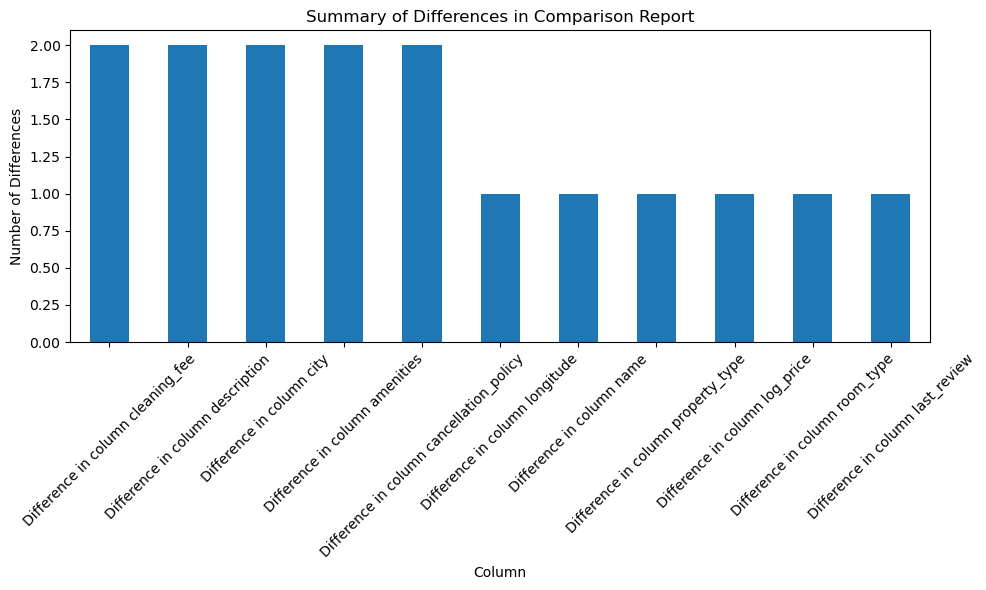

In [7]:
import pandas as pd
# Step 1: Load the two tables/queries into DataFrames

table_1 = pd.read_csv(r'C:\Users\asus\OneDrive\Desktop\Airbnb_Data_changed1.csv')
table_2 = pd.read_csv(r'C:\Users\asus\OneDrive\Desktop\Airbnb_Data_changed.csv')

# Specify the primary key column names
primary_key = ['id'] # Can use composite keys, but must generate uniqueness 

# Function to check for duplicate primary keys 
def find_duplicates(df, primary_key):
    duplicate_rows = df[df.duplicated(subset=primary_key, keep=False)]
    return duplicate_rows  # Returns rows with duplicates

# For Loop to ensure the primary keys exist in each column, otherwise generate an error message. 
for pk in primary_key:
    if pk not in table_1.columns or pk not in table_2.columns:
        raise ValueError(f"Primary key '{pk}' is missing from one of the tables. Please check the primary key values")


# Check for duplicates in both tables
duplicates_table_1 = find_duplicates(table_1, primary_key)
duplicates_table_2 = find_duplicates(table_2, primary_key)

# If duplicates are found, report the primary keys and raise an error
if not duplicates_table_1.empty:
    duplicate_keys = duplicates_table_1[primary_key].drop_duplicates().to_string(index=False)
    raise ValueError(f"Duplicate primary keys found in Table_1:\n{duplicate_keys}. Please correct the data")

if not duplicates_table_2.empty:
    duplicate_keys = duplicates_table_2[primary_key].drop_duplicates().to_string(index=False)
    raise ValueError(f"Duplicate primary keys found in Table_2:\n{duplicate_keys}. Please correct the data")

# Initialize report data
report_data = [] #Uses a list which data is then appended to 

# Sort and set the primary key as index
table_1 = table_1.sort_values(by=primary_key).set_index(primary_key)
table_2 = table_2.sort_values(by=primary_key).set_index(primary_key)

# Find common columns between the two tables
common_columns = set(table_1.columns) & set(table_2.columns)

# Identify missing rows between the two tables
merged = table_1.merge(table_2, how='outer', on=primary_key, indicator=True)

missing_rows_table_1 = merged[merged['_merge'] == 'right_only']
missing_rows_table_2 = merged[merged['_merge'] == 'left_only']

# Check for column differences
column_diff_counts = {}


# Fill missing values with a placeholder (e.g., -999) before comparison
table_1_filled = table_1.fillna('null')
table_2_filled = table_2.fillna('null')

# Check for column differences
column_diff_counts = {}

for column in common_columns:
    # Ensure indices are consistent before comparison
    table_1_filled = table_1_filled.reindex(table_2_filled.index)

    # Identify rows that are present in both tables
    present_in_both = table_1_filled[column].notna() & table_2_filled[column].notna()

    # Compare values only for rows present in both tables
    differences = table_1_filled.loc[present_in_both, column] != table_2_filled.loc[present_in_both, column]
    different_rows = table_1_filled.loc[present_in_both][differences]

    if not different_rows.empty:
        column_diff_counts[column] = len(different_rows)

        for idx in different_rows.index:
            table_1_value = table_1_filled.loc[idx, column]
            table_2_value = table_2_filled.loc[idx, column]
            report_data.append({
                'Primary Key': idx,
                'Issue': f'Difference in column {column}',
                'Table_1': table_1_value,
                'Table_2': table_2_value
            })
            
# Add missing rows to the report
if not missing_rows_table_1.empty: #Table 1
    for idx in missing_rows_table_1.index:
        report_data.append({
            'Primary Key': idx,
            'Issue': 'Missing in Table_1',
            'Table_1': 'Missing',
            'Table_2': 'Exists'
        })

if not missing_rows_table_2.empty: #Table 2 
    for idx in missing_rows_table_2.index:
        report_data.append({
            'Primary Key': idx,
            'Issue': 'Missing in Table_2',
            'Table_1': 'Exists',
            'Table_2': 'Missing'
        })

# Create a DataFrame for the report
report_df = pd.DataFrame(report_data)

# Count the number of missing rows in each table
num_missing_rows_table_1 = len(missing_rows_table_1)
num_missing_rows_table_2 = len(missing_rows_table_2)

# Save the report to a CSV file
report_filename = 'test8003.csv'
report_df.to_csv(report_filename, index=False)

print(f"Report saved to {report_filename}")

import pandas as pd
import matplotlib.pyplot as plt

# Load the comparison report CSV file
report_df = pd.read_csv(report_filename)

# Count the number of differences for each column
column_diff_counts = report_df[report_df['Issue'].str.startswith('Difference')]['Issue'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
column_diff_counts.plot(kind='bar')
plt.xlabel('Column')
plt.ylabel('Number of Differences')
plt.title('Summary of Differences in Comparison Report')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image
plt.savefig('differences_summary.png')

# Generate the Markdown text to embed the image into the report file
markdown_text = f"## Summary of Differences\n\n![Differences Summary](differences_summary.png)\n\n"

# Append the Markdown text to the comparison report file
with open('comparison_report.md', 'a') as f:
    f.write(markdown_text)
     